In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from statsmodels.tsa.arima_process import ArmaProcess
from pandas_datareader import data as wb 
from scipy.stats import norm

In [2]:
#min_rmsevals = np.random.randint(5,30,size = 20)

In [3]:
#we take mean prediction for regression in ensemble models for same data sample

In [4]:
#Bootstrap Samples
main_df = pd.read_csv('alldata.csv')

In [85]:
df_3 = pd.read_csv('alldata.csv')

In [5]:
main_df = main_df[['TSLA','SP500','Mkt-RF','SMB','HML','Vol TSLA']]

In [64]:
df_2 = main_df[:]

In [6]:
train_dat = pd.DataFrame(main_df[:500])

In [7]:
type(train_dat)

pandas.core.frame.DataFrame

In [28]:
test_dat = main_df[501:670]

In [9]:
def bootstrapSamp():
    k = train_dat.sample(n = 500, replace = True)
    return k

In [10]:
bootsampList = []
for i in range(0,5):
    bootsampList.append(bootstrapSamp())

In [29]:
bootsampList[0].shape

(500, 8)

In [30]:
len(bootsampList)

5

In [12]:
RMSe_list1 = []

In [13]:
def calcRMSe(yhat,yact):
    yhat = np.asarray(yhat)
    yact = np.asarray(yact)
    rmse = (((np.sum((yhat-yact)**2))/500)**0.5)
    return rmse

In [48]:
mod_list = []

In [58]:
def applytoModels(bootsampList):
    for s in bootsampList:
        
        Y=s['TSLA']
        X=s['SP500']
        Y = pd.DataFrame(Y)
        X = pd.DataFrame(X)
        Y=np.matrix(Y)
        X=np.matrix(X)
        
        #First model CAPM
        intercept_arr1 = [1]*len(s["SP500"])
        XT1 = np.matrix(np.asarray([np.asarray(intercept_arr1),np.asarray(s['SP500'])]) )
        XTT1 = np.matrix(np.transpose(XT1))
        mult_1 = XT1*XTT1
        B1 = np.matrix(((np.linalg.inv(mult_1))*XT1)*Y)
        y_CAPM = np.matrix(XTT1*B1)
        
        #Second Model. Fama and French 3 factor model
        intercept_arr2 = [1]*len(s)
        XT2 = np.matrix(np.asarray([np.asarray(intercept_arr2),
                                np.asarray(s['Mkt-RF']), 
                                np.asarray(s['SMB']), 
                                np.asarray(s['HML'])]))
        XTT2 = np.matrix(np.transpose(XT2))
        mult_2 = XT2*XTT2
        B2 = np.matrix(((np.linalg.inv(mult_2))*XT2)*Y)
        y_3Factor = np.matrix(XTT2*B2)
        
        #Third model : previous return model
        intercept_arr3 = [1]*len(s)
        YT=np.matrix(Y)                
        XT3 = np.matrix(np.asarray([np.asarray(intercept_arr3),
                                np.asarray(s['TSLA'])])) 
        XTT3 = np.matrix(np.transpose(XT3))
        mult_3 = XT3*XTT3
        B3 = np.matrix(((np.linalg.inv(mult_3))*XT3)*Y)
        y_PRM = np.matrix(XTT3*B3)
        T=s["TSLA"]
        T_final=T.shift(-1)
        T_final=np.matrix(T_final)
        TfT = np.matrix(np.transpose(T_final))
        residual_3=TfT-y_PRM
        rmse3=np.asarray(residual_3)
        rmse3 = rmse3[~np.isnan(rmse3)]
        rmse33=rmse3*rmse3
        rmse333=np.sum(rmse33)
        rmse33 = (rmse333/499)**0.5
        
        
        #Fourth Model:  log function
        intercept_arr4 = [1]*len(s)
        s['log_ret'] = np.log(s['Vol TSLA'])
        XT4 = np.matrix(np.asarray([np.asarray(intercept_arr4),
                                np.asarray(s['TSLA']), 
                                np.asarray(s['log_ret'])]))
        XTT4 = np.matrix(np.transpose(XT4))
        mult_4 = XT4*XTT4
        B4 = np.matrix(((np.linalg.inv(mult_4))*XT4)*Y)
        s['TSLA_PREV'] = s['TSLA'].shift(-1)
        x=np.matrix(s['TSLA_PREV'])
        z=np.matrix(np.transpose(x))
        y_log = np.matrix(XTT4*B4)
        
        intercept_arr1 = [1]*len(test_dat)
        XT1 = np.matrix(np.asarray([np.asarray(intercept_arr1),np.asarray(test_dat['SP500'])]) )
        XTT1 = np.matrix(np.transpose(XT1))
        y_CAPM = np.matrix(XTT1*B1)
        
        
        intercept_arr2 = [1]*len(test_dat)
        XT2 = np.matrix(np.asarray([np.asarray(intercept_arr2),
                                np.asarray(test_dat['Mkt-RF']), 
                                np.asarray(test_dat['SMB']), 
                                np.asarray(test_dat['HML'])]))
        XTT2 = np.matrix(np.transpose(XT2))
        y_3Factor = np.matrix(XTT2*B2)
        
        intercept_arr3 = [1]*len(test_dat)
        YT=np.matrix(Y)                
        XT3 = np.matrix(np.asarray([np.asarray(intercept_arr3),
                                np.asarray(test_dat['TSLA'])])) 
        XTT3 = np.matrix(np.transpose(XT3))
        y_PRM = np.matrix(XTT3*B3)
        
        intercept_arr4 = [1]*len(test_dat)
        test_dat['log_ret'] = np.log(test_dat['Vol TSLA'])
        XT4 = np.matrix(np.asarray([np.asarray(intercept_arr4),
                                np.asarray(test_dat['TSLA']), 
                                np.asarray(test_dat['log_ret'])]))
        XTT4 = np.matrix(np.transpose(XT4))
        y_log = np.matrix(XTT4*B4)
        mod_list.append(y_log)
        temp1 = []
        temp1.append(calcRMSe(y_CAPM,test_dat['TSLA']))
        temp1.append(calcRMSe(y_3Factor,test_dat['TSLA']))
        temp1.append(calcRMSe(y_PRM, test_dat['TSLA']))
        temp1.append(calcRMSe(y_log,test_dat['TSLA']))
        RMSe_list1.append(temp1)

In [59]:
applytoModels(bootsampList)

/Users/shrikumarpatil/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [60]:
len(RMSe_list1)

5

In [61]:
RMSe_list1

[[530.63889751221802,
  448.11065563489331,
  268.89860480262655,
  268.8986048026286],
 [534.51412775073936,
  479.29481021443195,
  268.89860480262928,
  268.8986048026282],
 [513.90174661738035,
  509.7835046705589,
  268.89860480262911,
  268.89860480262814],
 [545.09650783568338,
  502.21405535328688,
  268.8986048026361,
  268.89860480262809],
 [582.15117286766986,
  457.36345353670117,
  268.89860480263121,
  268.89860480262752]]

def evaluateonTest(bootsampList):
    for s in bootsampList:
        #y1
        #y2
        #y3
        #y4
        templ = []
        temp1.append[calcRMSe(y1,test_dat['TSLA'])]
        temp1.append[calcRMSe(y2,test_dat['TSLA'])]
        temp1.append[calcRMSe(y3,test_dat['TSLA'])]
        temp1.append[calcRMSe(y4,test_dat['TSLA'])]
        RMSe_list1.append(temp1)

In [62]:
#dictionary with key:min rmse for that subsample and value is the index
min_rmsind_model = []
for v in RMSe_list1:
    #temp_minval = min(v)
    temp_minind = np.argmin(np.asarray(v))
    min_rmsind_model.append(temp_minind)

#the model which occurs max times ie which has minimum rmse most number of times
from collections import defaultdict
d = defaultdict(int)
for i in min_rmsind_model:
    d[i] += 1
result = max(d.iteritems(), key=lambda x: x[1])
print(result)

In [63]:
min_rmsind_model

[2, 3, 3, 3, 3]

In [ ]:
#Log model performs best 4 times, hence for prediction, we average values for ensemble, and choose log model.

In [90]:
mod_list2 = []
for a in mod_list:
    mod_list2.append(np.asarray(a))

In [104]:
p1 = mod_list2[0]
p2 = mod_list2[1]
p3 = mod_list2[2]
p4 = mod_list2[3]
p5 = mod_list2[4]

In [105]:
preds1 = []
for v in p1:
    temp = v[0]
    preds1.append(temp)
preds2 = []
for v in p2:
    temp = v[0]
    preds2.append(temp)
preds3 = []
for v in p3:
    temp = v[0]
    preds3.append(temp)
preds4 = []
for v in p4:
    temp = v[0]
    preds4.append(temp)
preds5 = []
for v in p5:
    temp = v[0]
    preds5.append(temp)

In [106]:
y_pred = [sum(x)*0.2 for x in zip(preds1, preds2, preds3, preds4, preds5)]

In [108]:
len(y_pred)

169

In [109]:
residuals = np.matrix(y_pred - test_dat['TSLA'])

In [110]:
n_samples = 169
from numpy.linalg import inv              
variance = ((1/n_samples)*(residuals.T))*(residuals)

In [113]:
variance

matrix([[  6.43175754e-26,   6.20997279e-26,   6.32086517e-26, ...,
           8.09514311e-26,   7.20800414e-26,   6.98621939e-26],
        [  6.20997279e-26,   5.99583580e-26,   6.10290430e-26, ...,
           7.81600024e-26,   6.95945227e-26,   6.74531528e-26],
        [  6.32086517e-26,   6.10290430e-26,   6.21188473e-26, ...,
           7.95557167e-26,   7.08372820e-26,   6.86576733e-26],
        ..., 
        [  8.09514311e-26,   7.81600024e-26,   7.95557167e-26, ...,
           1.01887146e-25,   9.07214314e-26,   8.79300027e-26],
        [  7.20800414e-26,   6.95945227e-26,   7.08372820e-26, ...,
           9.07214314e-26,   8.07793567e-26,   7.82938380e-26],
        [  6.98621939e-26,   6.74531528e-26,   6.86576733e-26, ...,
           8.79300027e-26,   7.82938380e-26,   7.58847969e-26]])

In [111]:
from numpy import sqrt
std = sqrt(variance)
std

matrix([[  2.53609100e-13,   2.49198170e-13,   2.51413308e-13, ...,
           2.84519650e-13,   2.68477264e-13,   2.64314574e-13],
        [  2.49198170e-13,   2.44863958e-13,   2.47040569e-13, ...,
           2.79571104e-13,   2.63807738e-13,   2.59717448e-13],
        [  2.51413308e-13,   2.47040569e-13,   2.49236529e-13, ...,
           2.82056230e-13,   2.66152742e-13,   2.62026093e-13],
        ..., 
        [  2.84519650e-13,   2.79571104e-13,   2.82056230e-13, ...,
           3.19197660e-13,   3.01199986e-13,   2.96529936e-13],
        [  2.68477264e-13,   2.63807738e-13,   2.66152742e-13, ...,
           3.01199986e-13,   2.84217094e-13,   2.79810361e-13],
        [  2.64314574e-13,   2.59717448e-13,   2.62026093e-13, ...,
           2.96529936e-13,   2.79810361e-13,   2.75471953e-13]])

df_3['Bollinger_lower'] = df_3['Y_predicted'].apply(lambda x : x - std)
df_3['Bollinger_upper'] = df_3['Y_predicted'].apply(lambda x : x + std)

In [ ]:
[x - std for x in y_pred]

In [ ]:
fig = plt.figure(figsize=(12,8))
plt.plot(df3['observation_date'], df3['Bollinger_lower'], label = 'Bollinger_lower', color = 'blue')
plt.plot(df3['observation_date'], df3['SP500'], label = 'Y_ACTUAL', color = 'green')
plt.plot(df3['observation_date'], df3['Bollinger_upper'], label = 'Bollinger_upper', color = 'red')
plt.title('Predicted SP500 daily index with respect to other 5 major stock prices')
plt.xlabel('Daily timestamps - - - - - - - - - - >')
plt.ylabel('SP500 value  - - - - - - - - - - >')
plt.legend()
plt.show()

In [75]:
# Moving Average based training signals for Apple stock
short_window = 8
long_window = 20

signals = pd.DataFrame(index=df_2.index)
signals['signal'] = 0.0

signals['short_mavg'] = df_2['TSLA'].rolling(window=short_window, min_periods=1, center=False).mean()
signals['long_mavg'] = df_2['TSLA'].rolling(window=long_window, min_periods=1, center=False).mean()
signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] 
                                            > signals['long_mavg'][short_window:], 1.0, 0.0)   
signals['positions'] = signals['signal'].diff()

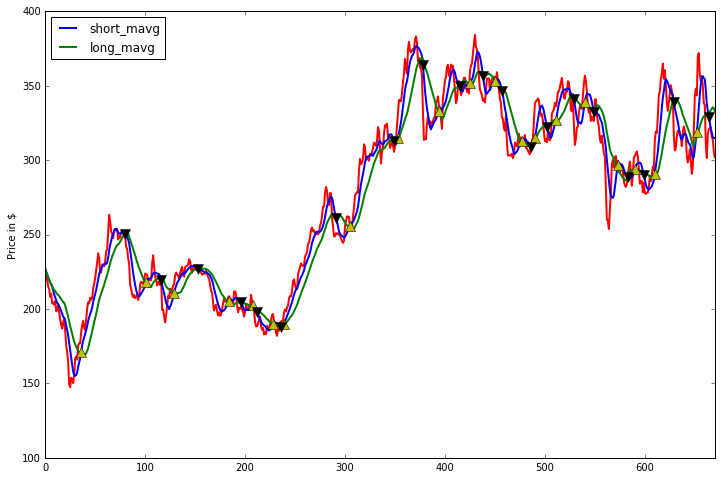

In [78]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(111,  ylabel='Price in $')
df_2['TSLA'].plot(ax=ax1, color='r', lw=2.)


signals[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2.)
ax1.plot(signals.loc[signals.positions == 1.0].index, 
         signals.short_mavg[signals.positions == 1.0],
         '^', markersize=10, color='y')

ax1.plot(signals.loc[signals.positions == -1.0].index, 
         signals.short_mavg[signals.positions == -1.0],
         'v', markersize=10, color='k')
         
plt.show()

In [80]:
high = 65
low = 12
 
# By default, set everything to 0
df_2['Signal'] = 0

df_2.loc[df_2['TSLA'] > high, 'Signal'] = -1
 

df_2.loc[df_2['TSLA'] < low, 'Signal'] = 1
 
# We store only days where we go long/short, so that we can display them on the graph
buys = df_2.ix[df_2['Signal'] == 1]
sells = df_2.ix[df_2['Signal'] == -1]

/Users/shrikumarpatil/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/shrikumarpatil/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/shrikumarpatil/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pan

In [72]:
# data = prices + dates at least
def backtest(data):
    cash = 100000
    position = 0
    total = 0
     
    data['Total'] = 100000
    data['BuyHold'] = 100000
    positionBeginning = int(100000/float(data.iloc[0]['TSLA']))
    increment = 1000
     
    for row in data.iterrows():
        price = float(row[1]['TSLA'])
        signal = float(row[1]['Signal'])
         
        if(signal > 0 and cash - increment * price > 0):
            # Buy
            cash = cash - increment * price
            position = position + increment
            print(" Position = "+str(position)+" Cash = "+str(cash)+" // Total = {:,}".format(int(position*price+cash)))
             
        elif(signal < 0 and abs(position*price) < cash):
            # Sell
            cash = cash + increment * price
            position = position - increment
            print(" Position = "+str(position)+" Cash = "+str(cash)+" // Total = {:,}".format(int(position*price+cash)))
             
        data.loc[data.index == row[0], 'Total'] = float(position*price+cash)
        data.loc[data.index == row[0], 'BuyHold'] = price*positionBeginning
         
    return position*price+cash

In [88]:
# Backtest
backtestResult = int(backtest(df_2[0:2]))
print(("Backtest => {:,} USD").format(backtestResult))
perf = (float(backtestResult)/100000-1)*100
daysDiff = 35
perf = (perf/(daysDiff))*360
print("Annual return => "+str(perf)+"%")
 
 
# Compute Sharpe ratio
df_2["Return"] = df_2["Total"]/df_2["Total"].shift(1)-1
volatility = df_2["Return"].std()*252
sharpe = perf/volatility
print("Volatility => "+str(volatility)+"%")
print("Sharpe => "+str(sharpe))

 Position = -1000 Cash = 326920.0 // Total = 100,000
 Position = -2000 Cash = 550020.0 // Total = 103,820
Backtest => 103,820 USD
Annual return => 39.29142857142858%
Volatility => 292.85010931035157%
Sharpe => 0.13416907599576477


/Users/shrikumarpatil/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/shrikumarpatil/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/shrikumarpatil/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati